In [1]:
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from pax import core
import multihist
import sys
import os
import scipy.integrate as integrate1
from scipy.stats import norm
from runDB import get_name
import stat
import shutil
import matplotlib.pyplot as plt
import matplotlib
import analyze

%matplotlib inline

In [2]:
def get_run(run):
    mypax = core.Processor(config_names='XENON1T', config_dict={
        'pax': {
            'plugin_group_names': ['input', 'preprocessing'],
            'preprocessing':      ['CheckPulses.SortPulses',
                                   'CheckPulses.ConcatenateAdjacentPulses',],
            'input':              'Zip.ReadZipped',
            'encoder_plugin':     None,
            #'decoder_plugin':     'BSON.DecodeZBSON',
            'input_name':          run
        }
    })
    return mypax

In [3]:
from spe_acceptance import get_name
from spe_acceptance import rawdata_dir, data_dir_base
LED_run=17998
noise_run=17997
run_name = get_name(LED_run)
noise_name = get_name(noise_run)
run_name=os.path.join(rawdata_dir, run_name)
noise_name=os.path.join(rawdata_dir, noise_name)
led_processor = get_run(run_name)
noise_processor = get_run(noise_name)

processor MainProcess L66 INFO This is PAX version 6.8.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/spe_acceptance/rawdata/180331_1359/XENON1T-17998-000000000-000000999-000001000.zip (number 1/197 in folder) for reading
processor MainProcess L66 INFO This is PAX version 6.8.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/spe_acceptance/rawdata/180331_1340/XENON1T-17997-000000000-000000999-000001000.zip (number 1/196 in folder) for reading


In [4]:
# generator used to loop over events
def get_events(RUN):
    for event in RUN.get_events():
        event = RUN.process_event(event)
        yield event

In [5]:
led_event_generator = get_events(led_processor)
noise_event_generator = get_events(noise_processor)
N = 10000

n_channels=254
led_channels=np.ones(n_channels)
noise_channels=np.ones(n_channels)

led_amp_list1=np.ones(n_channels)
led_amp_list2=np.ones(n_channels)
noise_amp_list1=np.ones(n_channels)
noise_amp_list2=np.ones(n_channels)

led_medians = []
led_baselines = []
noise_medians = []
noise_baselines = []

led_abs_diffs=[]
led_diffs=[]
noise_abs_diffs= []
noise_diffs = []

amplitude_bounds=(-100,1000)

led_array1=[ [], [] ]
led_array2=[ [], [] ]
noise_array1=[ [], [] ]
noise_array2=[ [], [] ]
LED_window=[125,175] #hardcoded in spe_acceptance.py

for i in tqdm(range(N)):
    led_event = next(led_event_generator)
    noise_event = next(noise_event_generator)
    
    for ch, p in enumerate(led_event.pulses):
        w=p.raw_data
        led_channels[ch]=p.channel
        #first baseline type is median of full raw data
        led_baseline1 = np.median(p.raw_data)
        #second baseline type is median of just the first few samples, should be similar
        #to pax's baseline function
        pbaseline=w[:47]
        led_baseline2=np.mean(pbaseline)   
        led_medians.append(led_baseline1)
        led_baselines.append(led_baseline2)
        
        #flip and baseline in two ways
        w1=led_baseline1-w
        w2=led_baseline2-w
        
        led_diffs.append(led_baseline1-led_baseline2)
        led_abs_diffs.append(abs(led_baseline1-led_baseline2))
        
        #look at only LED window
        led_spe1=w1[LED_window[0]:LED_window[1]]
        led_spe2=w2[LED_window[0]:LED_window[1]]
        
        led_spe1.clip(-100, 1000)
        led_spe2.clip(-100,1000)
        
        led_amp_list1[ch]=max(led_spe1)
        led_amp_list2[ch]=max(led_spe2)
        
    led_array1[0].extend(led_channels)
    led_array1[1].extend(led_amp_list1)
        
    led_array2[0].extend(led_channels)
    led_array2[1].extend(led_amp_list2)
    
    for ch, p in enumerate(noise_event.pulses):
        w=p.raw_data
        noise_channels[ch]=p.channel
        #first baseline type is median of full raw data
        noise_baseline1 = np.median(p.raw_data)
        #second baseline type is median of just the first few samples, should be similar
        #to pax's baseline function
        pbaseline=w[:47]
        noise_baseline2=np.mean(pbaseline)   
        noise_medians.append(noise_baseline1)
        noise_baselines.append(noise_baseline2)
        
        #flip and baseline in two ways
        w1=noise_baseline1-w
        w2=noise_baseline2-w
        
        noise_diffs.append(noise_baseline1-noise_baseline2)
        noise_abs_diffs.append(abs(noise_baseline1-noise_baseline2))
        
        #look at only LED window
        noise_spe1=w1[LED_window[0]:LED_window[1]]
        noise_spe2=w2[LED_window[0]:LED_window[1]]
        
        noise_spe1.clip(-100, 1000)
        noise_spe2.clip(-100,1000)
        
        noise_amp_list1[ch]=max(noise_spe1)
        noise_amp_list2[ch]=max(noise_spe2)
        
    noise_array1[0].extend(noise_channels)
    noise_array1[1].extend(noise_amp_list1)
        
    noise_array2[0].extend(noise_channels)
    noise_array2[1].extend(noise_amp_list2)

 10%|█         | 1000/10000 [01:17<08:29, 17.67it/s]ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/spe_acceptance/rawdata/180331_1359/XENON1T-17998-000001000-000001999-000001000.zip (number 2/197 in folder) for reading
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/spe_acceptance/rawdata/180331_1340/XENON1T-17997-000001000-000001999-000001000.zip (number 2/196 in folder) for reading
 20%|█▉        | 1999/10000 [02:32<07:58, 16.73it/s]ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/spe_acceptance/rawdata/180331_1359/XENON1T-17998-000002000-000002999-000001000.zip (number 3/197 in folder) for reading
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/spe_acceptance/rawdata/180331_1340/XENON1T-17997-000002000-000002999-000001000.zip (number 3/196 in folder) for reading
 30%|██▉       | 2998/10000 [03:51<05:46, 20.18it/s]Read

In [6]:
LED_multihist1 = multihist.Histdd(*tuple(led_array1),
                                  axis_names=['channel', 'amplitude'],
                                  bins=(np.arange(-1, n_channels + 1), 
                                        np.arange(*amplitude_bounds)))
    
LED_multihist2 = multihist.Histdd(*tuple(led_array2),
                                 axis_names=['channel', 'amplitude'],
                                 bins=(np.arange(-1, n_channels + 1),
                                       np.arange(*amplitude_bounds)))

noise_multihist1=multihist.Histdd(*tuple(noise_array1),
                                  axis_names=['channel', 'amplitude'],
                                  bins=(np.arange(-1, n_channels+1),
                                        np.arange(*amplitude_bounds)))

noise_multihist2=multihist.Histdd(*tuple(noise_array2),
                                  axis_names=['channel', 'amplitude'],
                                  bins=(np.arange(-1, n_channels+1),
                                        np.arange(*amplitude_bounds)))

In [7]:
LED_amp1=[]
LED_amp2=[]

noise_amp1=[]
noise_amp2=[]

for ch in range(248):
    LED_amp1.append(LED_multihist1.slice(ch, ch, 'channel').project('amplitude').histogram)

    LED_amp2.append(LED_multihist2.slice(ch, ch, 'channel').project('amplitude').histogram)
    
    noise_amp1.append(noise_multihist1.slice(ch, ch, 'channel').project('amplitude').histogram)
    
    noise_amp2.append(noise_multihist2.slice(ch, ch, 'channel').project('amplitude').histogram)

In [8]:
LED1=np.array(LED_amp1).T
LED2=np.array(LED_amp2).T

noise1=np.array(noise_amp1).T
noise2=np.array(noise_amp2).T

### Histograms of two different baseline methods

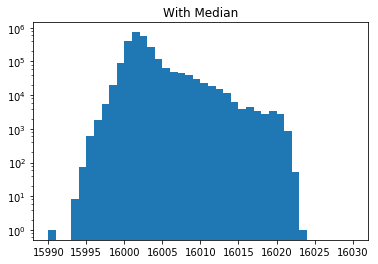

In [9]:
plt.hist(led_medians,  bins=40, range=(15990, 16030))
plt.title("With Median")
plt.yscale('log')
plt.show()

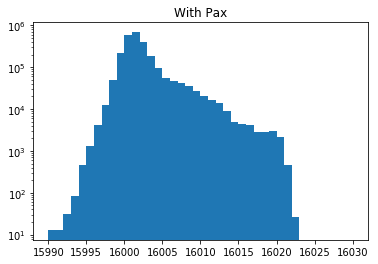

In [10]:
plt.hist(led_baselines,  bins=40, range=(15990, 16030))
plt.title("With Pax")
plt.yscale('log')
plt.show()

In [11]:
score=0
for diff in led_diffs:
    if -2<=diff<=2:
        score+=1
    else:
        continue
        
print(score/len(led_diffs))

0.9924031496062992


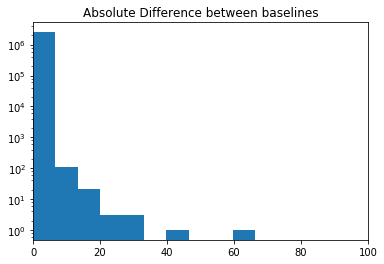

In [12]:
plt.figure()
plt.hist(led_abs_diffs, bins=80)
plt.title("Absolute Difference between baselines")
plt.yscale('log')
plt.xlim(0,100)
plt.show()

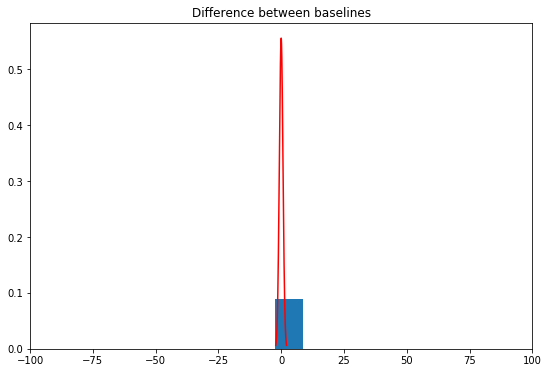

In [13]:
mu=np.mean(led_diffs)
sigma=np.std(led_diffs)
plt.figure(figsize=(9,6))
plt.hist(led_diffs, bins=50, normed=True)
plt.title("Difference between baselines")
x=np.linspace(mu-3*sigma, mu+3*sigma, num=1099)
gauss=norm(loc=mu, scale=sigma)
plt.plot(x, gauss.pdf(x), color='r')
plt.xlim(-100,100)
#plt.yscale('log')
plt.show()

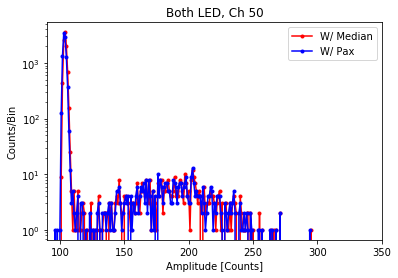

In [14]:
ch=50

plt.figure()
plt.plot(np.arange(1099), LED1.T[ch], color='r', marker='.',  label="W/ Median")# linestyle='None')
plt.plot(np.arange(1099), LED2.T[ch], color='b', marker='.', label="W/ Pax")#linestyle="None")
plt.xlim(90, 350)
plt.title('Both LED, Ch %d' %ch)
plt.xlabel("Amplitude [Counts]")
plt.ylabel("Counts/Bin")
plt.yscale('log')
plt.legend(loc='best')
plt.show()

/home/awalsh272/SPE/SPE/analyze.py:85: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)


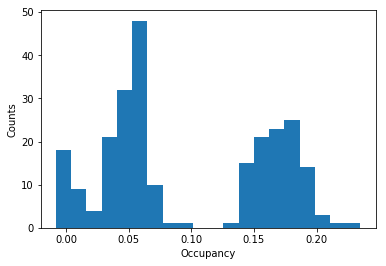

In [15]:
s=analyze.SPE(os.path.join(data_dir_base, 'run_%d.h5' %int(LED_run)))

corr, sig_corr=s.make_correction(6, 'amplitude')
occ=-1*np.log(corr)

plt.figure()
plt.hist(occ, bins=20)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.show()

In [16]:


def make_correction(val2corr2, space):  
    if space not in ['amplitude', 'charge']:
        raise ValueError('must specify amplitude or charge')
    #led = np.array(s.data['LED_%s' % space].copy())
    #noise = np.array(s.data['noise_%s' % space].copy())
    #print('noise: ',*noise)
    #sigma_led=np.sqrt(led)
    #sigma_noise=np.sqrt(noise)
    #led1=np.array(LED1)
    #led2=np.array(LED2)
    #print('led1: ', *led1)
    bin2corr2 = np.where(s.data['bin_centers'] == val2corr2 + 0.5)[0][0]
    led1_firstN = LED1[:bin2corr2, :].sum(axis=0)
    #print('ledfirstN:' ,led1_firstN)
    #print(np.shape(led1_firstN))
    led2_firstN = LED2[:bin2corr2, :].sum(axis=0)
    noise1_firstN = noise1[:bin2corr2,:].sum(axis=0)
    noise2_firstN = noise2[:bin2corr2,:].sum(axis=0)
    #sigma_led_firstN=np.sqrt(np.sum(sigma_led[:bin2corr2, :]**2, axis=0))
    #sigma_noise_firstN=np.sqrt(np.sum(sigma_noise[:bin2corr2,:]**2, axis=0))

    corr1_1=led1_firstN / noise1_firstN
    corr2_2=led2_firstN / noise2_firstN
    #sigma_corr=corr*np.sqrt((sigma_led_firstN/led_firstN)**2 + (sigma_noise_firstN/noise_firstN)**2)
    return corr1_1, corr2_2#, sigma_corr


In [17]:
corr1_1, corr2_2= make_correction(6, 'amplitude')
print('corr shape: ',np.shape(corr1_1))
print('corr1: ',corr1_1)
occ1=np.ones(248)
occ2=np.ones(248)
occ1=-1*np.log(corr1_1)
occ2=-1*np.log(corr2_2)
print('occ1: ', occ1)

corr shape:  (248,)
corr1:  [ 0.973292    1.02899137  1.01347368  0.98465985  0.96281224  1.08477918
  0.97771406  0.97194772  0.97339102  0.96637376  0.9815658   0.96999423
  0.9521967   0.95996411  0.96088616  0.97344353  0.97996751  0.96930892
  0.96377735  0.92408759  0.96839047  0.9671078   0.96852146  1.06196297
  0.96652406  0.95922438  0.99772339  0.94104185  0.95432569  0.96141375
  0.96989314  0.96626054  0.91187739  0.96113765  0.99673984  0.97294538
  0.98526225  0.94965298  0.96360738  0.92574541  1.00305632  0.93016156
  0.9547013   0.89895924  0.95763644  0.9480752   0.95081179  0.90447484
  0.97071038  0.96486964  0.96477931  0.95533141  0.95829323  0.97262795
  0.95362285  0.96058065  0.9554154   0.95894671  0.94694751  0.95272727
  0.94848318  0.95922598  1.00852605  0.93489755  0.89454501  0.96977484
  0.70764618  0.96395228  0.99286216  0.94791667  0.94324045  0.95147039
  0.958343    0.9596637   0.94220945  0.93727876  0.94236209  0.96923438
  0.95064103  0.9992856

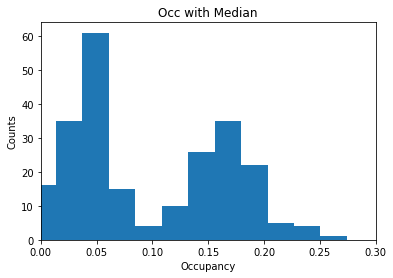

In [18]:
plt.figure()
plt.hist(occ1, bins=20)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.title("Occ with Median")
plt.xlim(0,0.3)
plt.show()


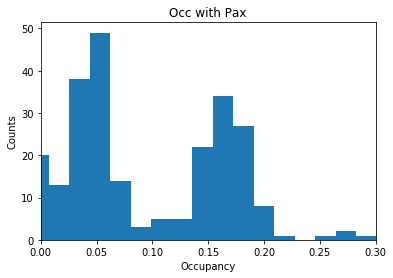

In [19]:
plt.figure()
plt.hist(occ2, bins=20)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.title("Occ with Pax")
plt.xlim(0,0.3)
plt.show()

0.0145289721152
0.842741935483871


/project/lgrandi/anaconda3/envs/pax_v6.8.0/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


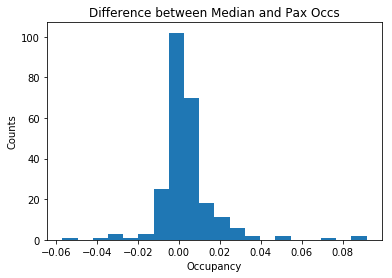

In [20]:
occ_diff=occ1-occ2
abs_occ_diff=abs(occ1-occ2)
print(np.std(occ_diff))

score=0
for diff in occ_diff:
    if -0.014<=diff<=0.014:
        score+=1
    else:
        continue
        
print(score/len(occ_diff))

plt.figure()
plt.hist(occ_diff, bins=20)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.title("Difference between Median and Pax Occs")
plt.legend()
plt.show()

/project/lgrandi/anaconda3/envs/pax_v6.8.0/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


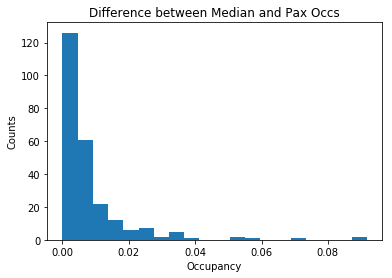

In [21]:
plt.figure()
plt.hist(abs_occ_diff, bins=20)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.title("Difference between Median and Pax Occs")
plt.legend()
plt.show()